In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
import datetime


%load_ext tensorboard

In [2]:
dataset = tfds.load("eurosat", split="train[25%:75%]")

In [3]:
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = int(0.05 * len(dataset))

dataset = dataset.shuffle(len(dataset))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [4]:
print("train size", train_size) 
print("val size", val_size) 
print("test size", test_size)

train size 12150
val size 675
test size 675


## settings

In [5]:
IMAGE_SIZE = (64,64,3) 

LABELS = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]
BATCH_SIZE = 16
EPOCHS = 100
TEST_SIZE = 0.18
LR = 0.001

### exploring the dataset

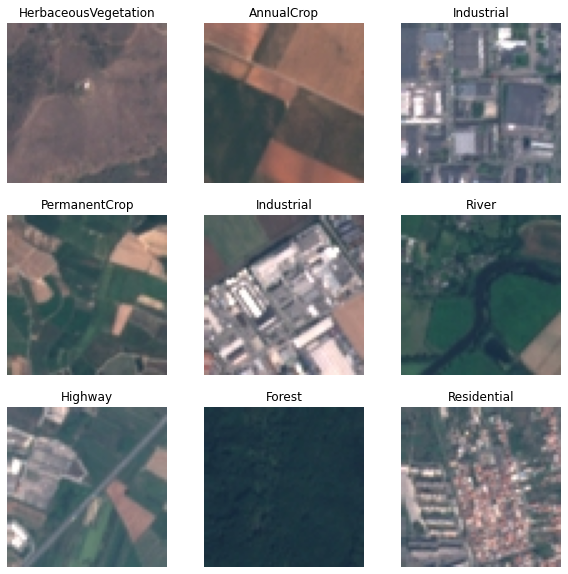

In [6]:
plt.figure(figsize=(10, 10))
for i,sample in enumerate(test_dataset.take(9)):
    image = sample["image"] 
    label = sample["label"]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(LABELS[int(label)])
    plt.axis("off")

In [7]:
def count_classes(dataset): 
    count = {} 
    for sample in dataset: 
        label = sample["label"].numpy()
        
        if label in count: 
            count[label] += 1
        else: 
            count[label] = 1
    print
    return count

In [8]:
sorted_labels = sorted(LABELS)
def plot_counts(): 
    f, ax = plt.subplots(3,1, figsize=(20,10))
    
    for i,dataset in enumerate([train_dataset, test_dataset, val_dataset]): 
        count = count_classes(dataset)
        count_sorted = {key:count[key] for key in sorted(count)}
        labels = [LABELS[key] for key in count_sorted.keys()]
        ax[i].bar(height=count_sorted.values(), x=labels)
        ax[i].set_title(f"class distribution for dataset {i}")

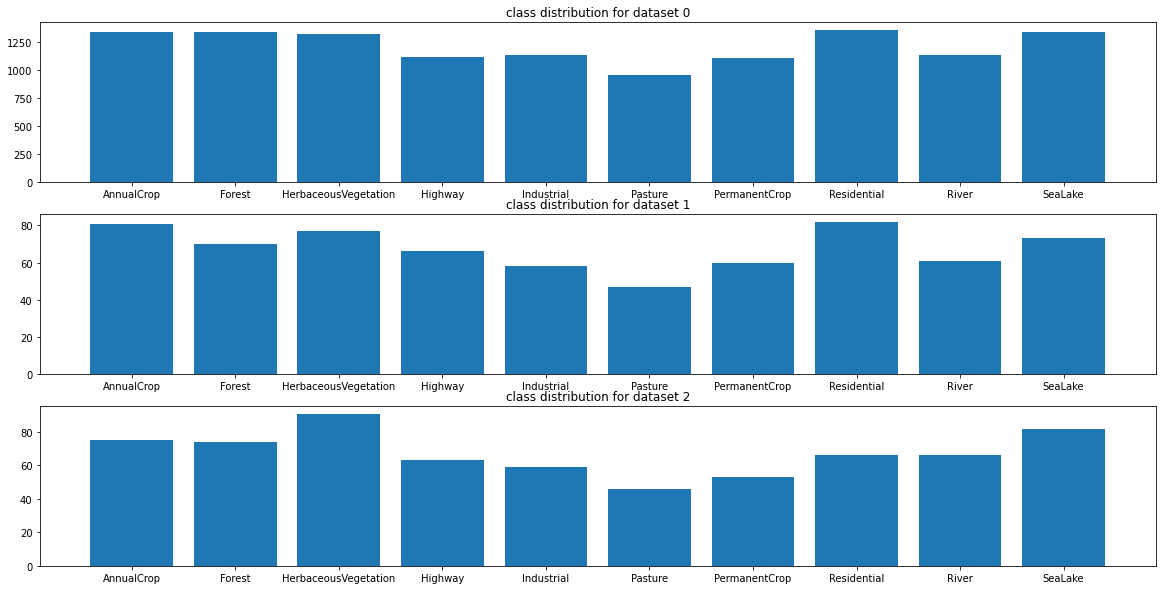

In [9]:
plot_counts()

### Tiny Resnet50

<ul>
    <li>We  perform  downsampling  directly  byconvolutional layers that have a stride of <strong>2</strong></li>
</ul>

In [10]:
def data_augmentation(): 
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    x = inputs
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.4)(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x])

data_augm = data_augmentation()

In [11]:
def residual_block(inputs, filters, kernel_size, is_downsampled=False):
    """
        compute a complete residual block 
        Arguments: 
            inputs: an input tensor
            filters: a list of the number of filters for each conv layer 
            kernel_size: a list of kernel sizes for each conv layer
    """
    if len(filters) != len(kernel_size): 
        return None
    
    identity = inputs 
    x = inputs 
    for i in range(len(filters)): 
        if is_downsampled and i == 0: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=2
            )(x)
        else: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=1
            )(x)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    if is_downsampled: 
        # we downsample the identity block by using 1x1 filters with a stride of 2
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=2)(identity)
    else: 
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=1)(identity)
    outputs = identity + x  
    outputs = tf.keras.activations.relu(outputs)
    
    return outputs


def tiny_resnet50(nb_classses, input_shape): 
    
    inputs = tf.keras.Input(shape=(64,64,3)) 
    
    x_augm = data_augm(inputs)
    
    first_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x_augm)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(first_conv)
    
    # stacking residual blocks
    all_filters = [
        [28,28, 64], 
        [128,128,128]
    ]
    
    kernel_sizes = [1,3,1]
    
    for filters in all_filters: 
        for i in range(2): 
            if i == 0: 
                downsample = True
            else: 
                downsample = False
            
            x = residual_block(x,filters,kernel_sizes, is_downsampled=downsample)
            
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.AveragePooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nb_classses)(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
    

In [12]:
resnet50 = tiny_resnet50(len(LABELS), IMAGE_SIZE)
print(IMAGE_SIZE)

(64, 64, 3)


In [13]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        model[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
____________________________________________________________________________________________

In [14]:
def preprocess_data(sample):
    image = tf.cast(sample["image"], dtype=tf.float32)
    label = tf.one_hot(
        sample["label"], 
        depth=len(LABELS)
    )
    
    return (image, label)

### Training 

In [15]:
# lr decay 

def lrdecay(epoch, lr): 
    k = 0.02
    if epoch >= 5: 
        lr = lr * np.exp(-k*epoch) 
    return lr

In [16]:
log_dir = F"logs/fit/reduced_model_lr={LR}_decay={EPOCHS}_dropout_decay_inverted_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True, verbose=1), 
    tf.keras.callbacks.LearningRateScheduler(lrdecay, verbose=1)
]

### Do not run if you've already trained the model

In [17]:
train_dataset = train_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

train_dataset = train_dataset.batch(BATCH_SIZE) 
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
resnet50.compile(
    optimizer=tf.keras.optimizers.SGD(LR),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [19]:
resnet50.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_dataset,
)


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
760/760 [==============================] - 17s 17ms/step - loss: 2.0978 - accuracy: 0.1143 - val_loss: 1.9463 - val_accuracy: 0.1170

Epoch 00001: val_loss improved from inf to 1.94626, saving model to best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
760/760 [==============================] - 12s 16ms/step - loss: 1.8556 - accuracy: 0.1374 - val_loss: 1.6202 - val_accuracy: 0.1970

Epoch 00002: val_loss improved from 1.94626 to 1.62017, saving model to best_model.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
760/760 [==============================] - 12s 16ms/step - loss: 1.5677 - accuracy: 0.3386 - val_loss: 1.3150 - val_accuracy: 0.4859

Epoch 00003: val_loss improved from 1.62017 to 1.31502, saving model to best_model.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler reduc

760/760 [==============================] - 12s 15ms/step - loss: 0.7512 - accuracy: 0.7295 - val_loss: 0.6972 - val_accuracy: 0.7600

Epoch 00028: val_loss did not improve from 0.67393
Epoch 29/100

Epoch 00029: LearningRateScheduler reducing learning rate to 3.634023050206373e-07.
760/760 [==============================] - 12s 16ms/step - loss: 0.7424 - accuracy: 0.7334 - val_loss: 0.6615 - val_accuracy: 0.7644

Epoch 00029: val_loss improved from 0.67393 to 0.66154, saving model to best_model.h5
Epoch 30/100

Epoch 00030: LearningRateScheduler reducing learning rate to 2.0346835829546106e-07.
760/760 [==============================] - 12s 16ms/step - loss: 0.7505 - accuracy: 0.7311 - val_loss: 0.6577 - val_accuracy: 0.7748

Epoch 00030: val_loss improved from 0.66154 to 0.65773, saving model to best_model.h5
Epoch 31/100

Epoch 00031: LearningRateScheduler reducing learning rate to 1.1166580375485068e-07.
760/760 [==============================] - 12s 16ms/step - loss: 0.7475 - accur


Epoch 00056: val_loss did not improve from 0.63859
Epoch 57/100

Epoch 00057: LearningRateScheduler reducing learning rate to 1.675633488279323e-17.
760/760 [==============================] - 12s 15ms/step - loss: 0.7584 - accuracy: 0.7269 - val_loss: 0.6826 - val_accuracy: 0.7526

Epoch 00057: val_loss did not improve from 0.63859
Epoch 58/100

Epoch 00058: LearningRateScheduler reducing learning rate to 5.358994662679707e-18.
760/760 [==============================] - 12s 15ms/step - loss: 0.7574 - accuracy: 0.7248 - val_loss: 0.7163 - val_accuracy: 0.7556

Epoch 00058: val_loss did not improve from 0.63859
Epoch 59/100

Epoch 00059: LearningRateScheduler reducing learning rate to 1.6799707663124792e-18.
760/760 [==============================] - 12s 16ms/step - loss: 0.7531 - accuracy: 0.7284 - val_loss: 0.6798 - val_accuracy: 0.7585

Epoch 00059: val_loss did not improve from 0.63859
Epoch 60/100

Epoch 00060: LearningRateScheduler reducing learning rate to 5.162192889124408e-19.


760/760 [==============================] - 12s 15ms/step - loss: 0.7594 - accuracy: 0.7240 - val_loss: 0.7134 - val_accuracy: 0.7496

Epoch 00085: val_loss did not improve from 0.62570
Epoch 86/100

Epoch 00086: LearningRateScheduler reducing learning rate to 2.1874204066816433e-35.
760/760 [==============================] - 12s 15ms/step - loss: 0.7431 - accuracy: 0.7333 - val_loss: 0.6364 - val_accuracy: 0.7659

Epoch 00086: val_loss did not improve from 0.62570
Epoch 87/100

Epoch 00087: LearningRateScheduler reducing learning rate to 3.9169293700218946e-36.
760/760 [==============================] - 12s 15ms/step - loss: 0.7591 - accuracy: 0.7245 - val_loss: 0.6720 - val_accuracy: 0.7600

Epoch 00087: val_loss did not improve from 0.62570
Epoch 88/100

Epoch 00088: LearningRateScheduler reducing learning rate to 6.875009819797926e-37.
760/760 [==============================] - 12s 15ms/step - loss: 0.7522 - accuracy: 0.7266 - val_loss: 0.6712 - val_accuracy: 0.7541

Epoch 00088: va

In [20]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 7453), started 9:34:06 ago. (Use '!kill 7453' to kill it.)

## Observations of the naïve resnet50 model

### The model is overfitting with basic data augm, lr=0.01, no dropout

<p>Possible solutions for this problem</p>

<ol>
    <li>More data</li>
    <li>Adding Data Augmentation </li>
    <li>Adding regularization (Lr decay, Dropout)</li>
    <li>Reduce complexity</li>
</ol>

### Let's test our model

In [21]:
resnet50 = tiny_resnet50(len(LABELS), IMAGE_SIZE)
resnet50.load_weights("best_model.h5")

In [22]:
def get_true_label(image, label): 
    return tf.math.argmax(label)

In [23]:
val_dataset = val_dataset.map(preprocess_data)

HerbaceousVegetation
Pasture
AnnualCrop
Industrial
PermanentCrop
River
Industrial
AnnualCrop
SeaLake
PermanentCrop
River
Industrial
PermanentCrop
HerbaceousVegetation
PermanentCrop
Forest
AnnualCrop
PermanentCrop
AnnualCrop
River
HerbaceousVegetation
AnnualCrop
Forest
River
SeaLake
AnnualCrop
AnnualCrop
AnnualCrop
AnnualCrop
River
HerbaceousVegetation
PermanentCrop
Highway
River
Pasture
HerbaceousVegetation
Highway
River
Highway
River
Industrial
HerbaceousVegetation
AnnualCrop
Industrial
Highway
Pasture
AnnualCrop
Residential
Residential
Forest
River
HerbaceousVegetation
SeaLake
Forest
River
Industrial
HerbaceousVegetation
Pasture
Residential
Highway
PermanentCrop
AnnualCrop
AnnualCrop
Industrial
Pasture
Forest
Residential
PermanentCrop
Pasture
AnnualCrop
Residential
PermanentCrop
Pasture
Forest
Forest
HerbaceousVegetation
Forest
Industrial
Highway
Pasture
HerbaceousVegetation
HerbaceousVegetation
River
Forest
Forest
Highway
River
HerbaceousVegetation
PermanentCrop
Forest
Residential
R

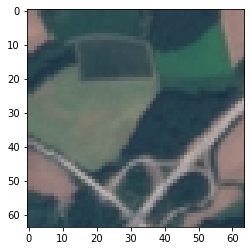

In [24]:
val_images = []
val_labels = [] 

for sample in list(val_dataset.as_numpy_iterator()): 
    val_images.append(sample[0]) 
    val_labels.append(sample[1])
    
    plt.imshow(sample[0].astype("uint8"))
    print(LABELS[np.argmax(sample[1])])

In [25]:
np.array(val_images).shape

(675, 64, 64, 3)

In [26]:
probs = resnet50.predict(np.array(val_images))
preds = np.argmax(probs, axis=-1)
print(preds)

[7 5 0 4 6 8 4 0 9 6 5 7 6 2 3 1 0 6 0 8 2 0 1 5 9 0 0 0 0 8 6 6 8 8 5 0 6
 8 3 8 4 2 0 4 8 5 0 7 7 1 8 2 9 1 8 4 6 5 7 8 6 3 0 4 5 1 7 6 5 0 7 2 5 1
 1 2 1 4 8 5 2 2 8 1 1 5 8 2 6 1 7 8 4 4 0 0 5 8 9 5 3 7 7 7 3 7 0 4 1 9 6
 1 2 1 9 3 2 0 1 9 3 6 1 1 0 3 4 8 2 1 1 3 0 4 4 1 5 8 5 8 8 4 4 5 8 0 5 4
 5 0 0 0 9 9 6 9 1 4 1 8 6 4 1 5 6 0 9 0 0 4 8 8 7 2 3 4 0 2 4 6 1 4 1 7 1
 3 8 6 7 5 1 1 7 9 8 7 4 1 7 2 9 9 8 7 4 2 0 1 3 0 7 1 2 7 6 5 2 6 9 7 0 8
 0 7 7 4 1 7 9 3 2 4 4 9 6 8 0 9 4 0 4 0 2 8 4 4 2 8 5 8 7 7 7 4 3 8 1 7 8
 7 6 9 7 6 9 8 4 4 7 3 7 0 2 9 2 5 3 6 9 7 0 3 5 9 8 7 6 5 1 8 1 3 9 7 2 0
 7 3 5 3 9 9 2 6 0 8 2 0 9 7 1 9 9 2 4 0 0 7 5 9 2 9 9 5 2 4 2 8 7 7 9 5 2
 9 3 5 0 8 6 1 2 5 0 8 0 1 7 6 2 7 2 7 1 4 1 9 1 3 8 1 5 3 7 5 0 4 7 4 6 0
 4 9 2 4 4 7 9 9 5 9 6 5 8 2 7 0 9 4 6 9 9 7 9 2 1 9 5 0 3 3 0 7 4 7 0 0 7
 1 2 4 7 1 4 7 1 3 7 0 0 4 1 1 6 4 8 5 5 0 7 7 3 7 2 7 8 0 6 9 2 3 5 4 8 2
 2 1 5 1 2 9 4 6 7 2 2 4 9 9 3 7 3 6 0 1 2 4 2 0 2 9 7 7 6 8 6 4 1 7 8 7 7
 1 9 1 3 7 8 0 4 4 9 8 0 

In [27]:
true_label = np.argmax(val_labels, axis=-1)
true_label

array([2, 5, 0, 4, 6, 8, 4, 0, 9, 6, 8, 4, 6, 2, 6, 1, 0, 6, 0, 8, 2, 0,
       1, 8, 9, 0, 0, 0, 0, 8, 2, 6, 3, 8, 5, 2, 3, 8, 3, 8, 4, 2, 0, 4,
       3, 5, 0, 7, 7, 1, 8, 2, 9, 1, 8, 4, 2, 5, 7, 3, 6, 0, 0, 4, 5, 1,
       7, 6, 5, 0, 7, 6, 5, 1, 1, 2, 1, 4, 3, 5, 2, 2, 8, 1, 1, 3, 8, 2,
       6, 1, 7, 8, 4, 4, 0, 0, 5, 8, 9, 8, 3, 7, 7, 7, 3, 7, 0, 4, 1, 9,
       6, 1, 2, 1, 9, 3, 2, 0, 1, 9, 8, 3, 1, 1, 0, 3, 4, 8, 8, 1, 1, 7,
       8, 4, 4, 1, 5, 9, 5, 8, 8, 4, 3, 5, 8, 0, 2, 4, 0, 0, 0, 0, 9, 9,
       6, 9, 1, 7, 1, 8, 6, 4, 1, 5, 6, 0, 9, 0, 0, 7, 3, 8, 7, 6, 3, 4,
       0, 2, 4, 2, 1, 4, 1, 2, 1, 5, 8, 2, 2, 1, 1, 1, 7, 9, 8, 7, 4, 9,
       2, 5, 9, 9, 8, 7, 4, 2, 0, 1, 3, 0, 7, 1, 8, 2, 2, 5, 2, 6, 9, 7,
       0, 8, 0, 7, 7, 4, 1, 7, 9, 3, 3, 4, 4, 9, 6, 3, 0, 9, 7, 0, 4, 0,
       2, 8, 4, 4, 2, 8, 8, 8, 3, 7, 3, 4, 3, 8, 1, 4, 8, 7, 3, 9, 7, 3,
       9, 8, 4, 4, 8, 3, 7, 0, 2, 9, 2, 5, 3, 6, 9, 7, 0, 8, 5, 9, 8, 7,
       6, 5, 1, 8, 1, 8, 9, 7, 2, 0, 7, 3, 5, 3, 9,

In [28]:
print(len(predictions))
print(len(true_label))

NameError: name 'predictions' is not defined

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
conf_mat = confusion_matrix(predictions, true_label)
score = f1_score(predictions, true_label,labels=range(len(LABELS)), average='macro')
precision = precision_score(predictions, true_label, labels=range(len(LABELS)), average='macro')

In [ ]:
def display_confusion_matrix(cmat):
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(LABELS)))
    ax.set_yticklabels(LABELS)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()


In [ ]:
display_confusion_matrix(conf_mat)
print(f"f1 : {score * 100} % , precision : {precision * 100} % ")